In [84]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_csv('Leads.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [3]:
# Let's check the missing values percentage in each column

round(100*data.isna().sum()/len(data),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [4]:
# Let's look into the data

data.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [5]:
# Remove the columns with more than 40% missing values

missing_values = data.isnull().sum()
missing_values_percentage = missing_values/len(data)
columns_to_drop = missing_values_percentage[missing_values_percentage > 0.4].index.tolist()
data = data.drop(columns_to_drop, axis=1)
data.shape

(9240, 32)

In [6]:
# Drop the "Prospect ID" and "Lead Number" columns as they serve no purpose in building the model

data = data.drop(["Prospect ID", "Lead Number"], axis=1)
data.shape

(9240, 30)

In [7]:
# Drop the columns that have a low number of "Yes", as they won't affect the model performance.

data = data.drop(["Receive More Updates About Our Courses","Magazine", "Search", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", "Through Recommendations", "Update me on Supply Chain Content", "Do Not Call", "Get updates on DM Content", "I agree to pay the amount through cheque" ], axis=1)
data.shape

(9240, 18)

In [8]:
# Let's look into the data

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9103.000000,9240.000000,9103.000000
mean,0.385390,3.445238,487.698268,2.362820
std,0.486714,4.854853,548.021466,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,12.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,936.000000,3.000000
max,1.000000,251.000000,2272.000000,55.000000


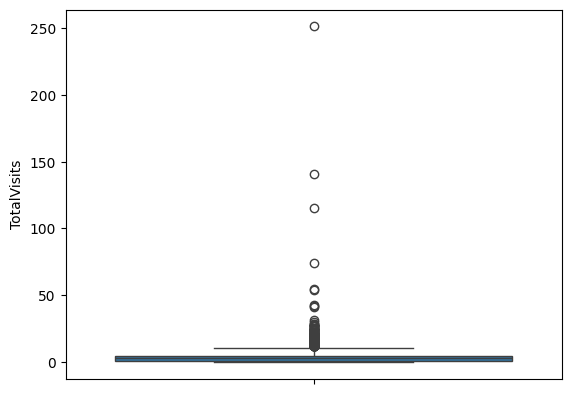

In [9]:
# Let's plot a boxplot for the TotalVisits column

sns.boxplot(data.TotalVisits)
plt.show()

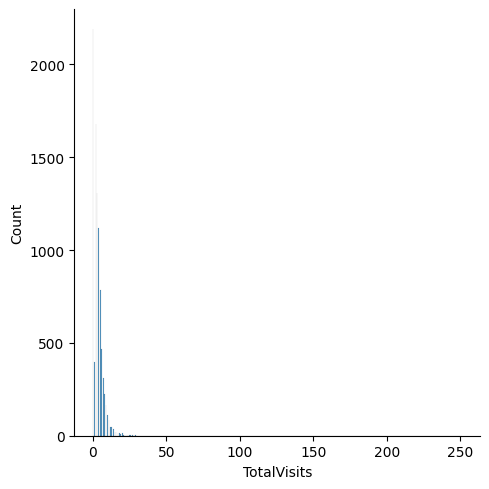

In [10]:
# Plot a histogram for the TotalVisits column

sns.displot(data.TotalVisits)
plt.show()

We can see that there are heavy outliers, skewing the data. Hence these outliers are to be removed.

In [11]:
# Remove the rows that have a high number of Total Visits (> 20), as they skew the entire column data

data = data[~(data.TotalVisits>20)]

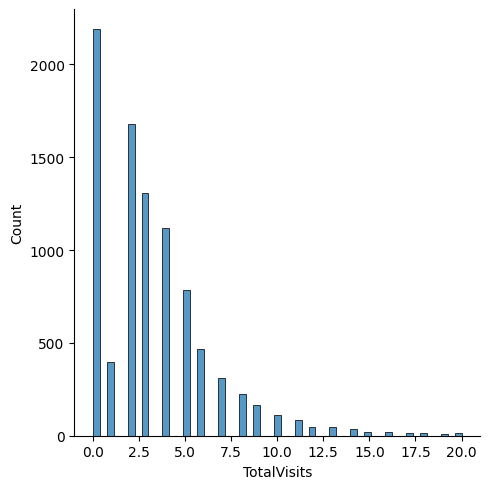

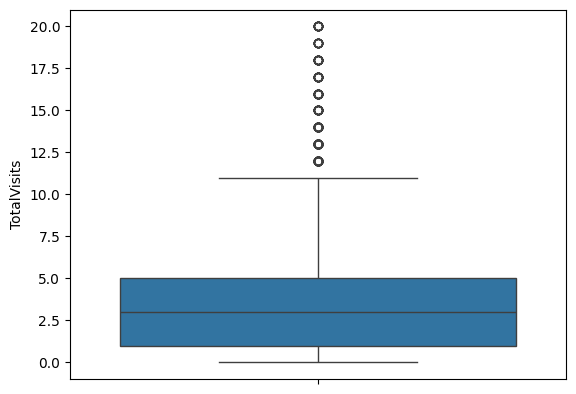

In [12]:
# Let's plot the histogram and boxplot for the TotalVisits column again

sns.displot(data.TotalVisits)
plt.show()
sns.boxplot(data.TotalVisits)
plt.show()

In [13]:
# Let's look into the data description again

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9193.000000,9056.000000,9193.000000,9056.000000
mean,0.385184,3.269435,487.005113,2.342778
std,0.486665,3.144111,547.923193,2.063161
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,11.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,935.000000,3.000000
max,1.000000,20.000000,2272.000000,16.000000


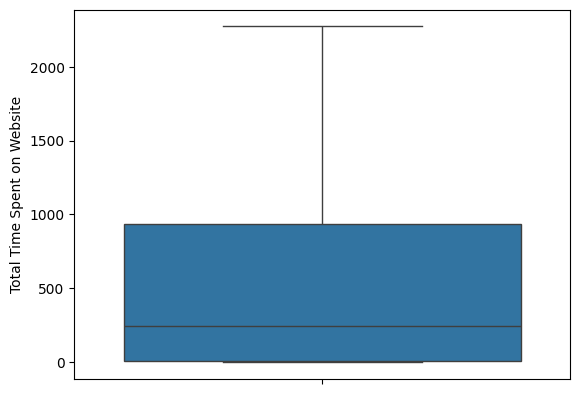

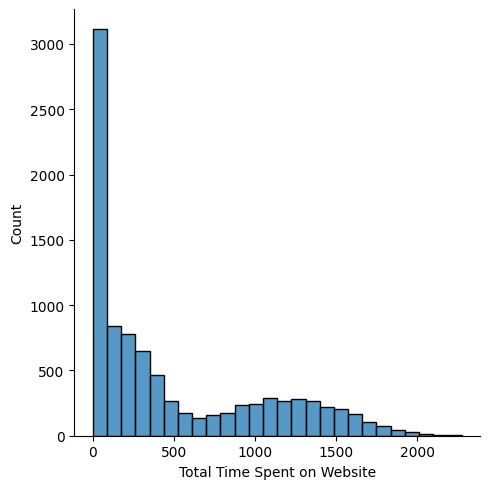

In [14]:
# Let's plot a boxplot and histogram for "Total Time Spent on Website"

sns.boxplot(data["Total Time Spent on Website"])
plt.show()
sns.displot(data["Total Time Spent on Website"])
plt.show()

There are no outliers in the "Total Time Spent on Website" column. But the data is heavily skewed towards the left end.

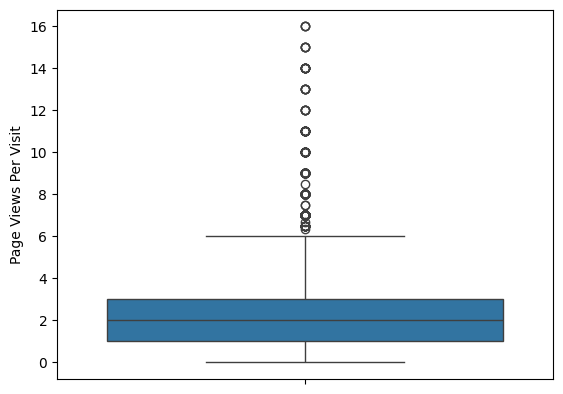

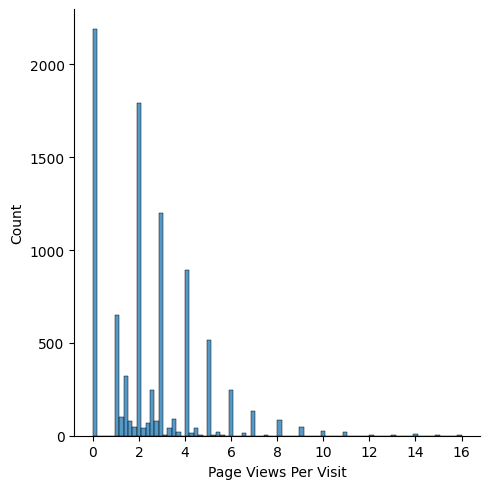

In [15]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column

sns.boxplot(data["Page Views Per Visit"])
plt.show()
sns.displot(data["Page Views Per Visit"])
plt.show()

In [16]:
# Let's remove the outliers from the "Page Views Per Visit" column (> 10 views per visit)

data = data[~(data["Page Views Per Visit"]>10)]

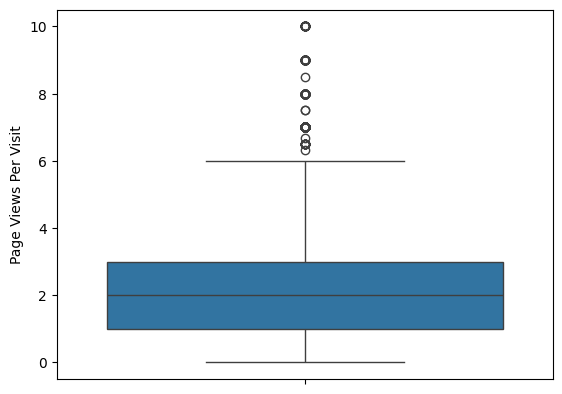

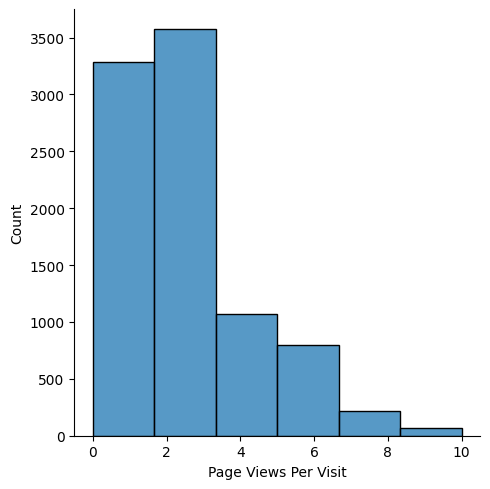

In [17]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column again

sns.boxplot(data["Page Views Per Visit"])
plt.show()
sns.displot(data["Page Views Per Visit"], bins=6)
plt.show()

In [18]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                             36.31
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [19]:
# Let's check the "Tags" column

100*data["Tags"].value_counts(normalize=True)

Tags
Will revert after reading the email                  35.284023
Ringing                                              20.353527
Interested in other courses                           8.752360
Already a student                                     7.945770
Closed by Horizzon                                    6.006521
switched off                                          4.084435
Busy                                                  3.174876
Lost to EINS                                          2.968938
Not doing further education                           2.368286
Interested  in full time MBA                          2.007894
Graduation in progress                                1.887764
invalid number                                        1.424404
Diploma holder (Not Eligible)                         1.081174
wrong number given                                    0.789429
opp hangup                                            0.566329
number not provided                               

Instead of having multiple categories in the Tags columns, we can have all the low significant categories clubbed together as "Others"

In [20]:
# Let's club low significant categories as "Others"
# Let's create a list of required categories

required_categories = data["Tags"].value_counts(normalize=True)[data["Tags"].value_counts(normalize=True) > 0.07].index.tolist()
required_categories

# Let's replace the other categories with "Others" and also impute missing categories as "Others"

data.Tags = data.Tags.fillna("Others")
data["Tags"] = data["Tags"].apply(lambda x: x if x in required_categories else "Others")
100*data["Tags"].value_counts(normalize=True)

Tags
Others                                 53.929391
Will revert after reading the email    22.472401
Ringing                                12.963165
Interested in other courses             5.574380
Already a student                       5.060662
Name: proportion, dtype: float64

In [21]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [22]:
# Let's check the "Lead Profile" column

100*data["Lead Profile"].value_counts(normalize=True)

Lead Profile
Select                         63.501392
Potential Lead                 24.698423
Other Leads                     7.423446
Student of SomeSchool           3.711723
Lateral Student                 0.355707
Dual Specialization Student     0.309310
Name: proportion, dtype: float64

There are some columns that have the value "Select" in it, which are as good as "Null" values, as they might be the default value for missing data/value that is not filled in while inputting the data. Hence we need to identify these columns and impute the values as Null and check the missing values percentage in each column again.

In [23]:
# Let's check the columns that have the value "Select" in them

columns_with_select = [col for col in data.columns if data[col].isin(['Select']).any()]

columns_with_select

['Specialization',
 'How did you hear about X Education',
 'Lead Profile',
 'City']

In [24]:
# Let's impute the "Select" value with Nulls

data[columns_with_select] = data[columns_with_select].replace('Select', np.nan)

In [25]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
City                                             39.95
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [26]:
# Let's check the City column

100*data["City"].value_counts(normalize=True)

City
Mumbai                         57.844922
Thane & Outskirts              13.396432
Other Cities                   12.413542
Other Cities of Maharashtra     8.227157
Other Metro Cities              6.789225
Tier II Cities                  1.328722
Name: proportion, dtype: float64

In [27]:
# Let's check the City column where the Country is not India, Asia/Pacific, unknowns or nulls

data[~(data["Country"].isin(["India", "Asia/Pacific", np.nan, "unknown"]))]["City"].value_counts(normalize=True)

City
Mumbai                         0.407080
Other Cities                   0.296460
Other Cities of Maharashtra    0.101770
Thane & Outskirts              0.092920
Other Metro Cities             0.088496
Tier II Cities                 0.013274
Name: proportion, dtype: float64

The City column is not aligned with the respective country cities and provided with some random data. Hence we can drop the City column. 

In [28]:
# Let's drop the City column

data = data.drop("City", axis=1)
data.shape

(9149, 17)

In [29]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [30]:
# Let's drop the columns "Lead Profile" and "How did you hear about X Education" as they have high number of missing values (> 70%)

data = data.drop(["Lead Profile", "How did you hear about X Education"], axis=1)
data.shape

(9149, 15)

In [31]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [32]:
# Let's check the "Specialization" column

100*data["Specialization"].value_counts(normalize=True)

Specialization
Finance Management                   16.686841
Human Resource Management            14.490749
Marketing Management                 14.352412
Operations Management                 8.663324
Business Administration               6.864949
IT Projects Management                6.259727
Supply Chain Management               5.965762
Banking, Investment And Insurance     5.775549
Media and Advertising                 3.441121
Travel and Tourism                    3.389244
International Business                3.026111
Healthcare Management                 2.697562
Hospitality Management                1.954003
E-COMMERCE                            1.902127
Retail Management                     1.642746
Rural and Agribusiness                1.227736
E-Business                            0.985648
Services Excellence                   0.674390
Name: proportion, dtype: float64

In [33]:
#  Let's create a new column "Specs" where we group different Specialisation values

finance = ['Finance Management', 'Banking, Investment And Insurance','E-COMMERCE','E-Business']
Management = ['Business Administration','Supply Chain Management','IT Projects Management','Human Resource Management','Marketing Management','Operations Management','Retail Management','Hospitality Management','Healthcare Management']
others = ['Media and Advertising','Travel and Tourism','International Business','Services Excellence','Rural and Agribusiness']


data['GroupedSpecialisation'] = data.Specialization.apply(lambda x: 'Finance' if x in finance else('Management' if x in Management else ('Others' if x in others else np.nan)))


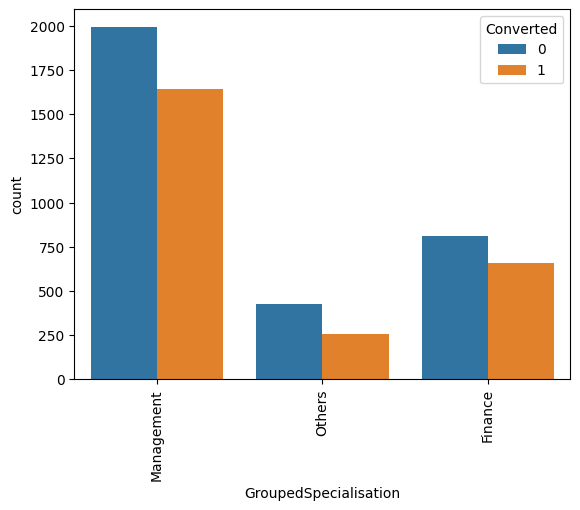

In [34]:
# Let's plot the count for each Specilisation group with respect to Converted column

sns.countplot(x=data['GroupedSpecialisation'],hue=data.Converted).tick_params(axis='x',rotation=90)
plt.show()

In [35]:
# Let's impute the missing values in Specs column with the value "Management"

data.GroupedSpecialisation = data.GroupedSpecialisation.fillna("Management")

# Let's drop the column "Specialization"

data = data.drop("Specialization", axis=1)
data.shape

(9149, 15)

In [36]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
GroupedSpecialisation                             0.00
dtype: float64

In [37]:
# Let's check the 'Country' column

100*data["Country"].value_counts(normalize=True)

Country
India                   95.738636
United States            1.016746
United Arab Emirates     0.792464
Singapore                0.358852
Saudi Arabia             0.313995
United Kingdom           0.224282
Australia                0.194378
Qatar                    0.149522
Hong Kong                0.104665
Bahrain                  0.104665
France                   0.089713
Oman                     0.089713
Germany                  0.059809
unknown                  0.059809
South Africa             0.059809
Nigeria                  0.059809
Kuwait                   0.059809
Canada                   0.059809
Sweden                   0.044856
China                    0.029904
Asia/Pacific Region      0.029904
Uganda                   0.029904
Bangladesh               0.029904
Italy                    0.029904
Belgium                  0.029904
Netherlands              0.029904
Ghana                    0.029904
Philippines              0.029904
Russia                   0.014952
Switze

In [38]:
# Since the majority of the Country values are "India", let's group the other countries together with "International" and impute missing values with "India"

data['Country'] = data.Country.fillna('India')
data['Country'] = data.Country.apply(lambda x: 'India' if x == 'India' else 'International')

In [39]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                           0.00
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
GroupedSpecialisation                             0.00
dtype: float64

In [40]:
# Let's rename the column "What is your current occupation" to "Occupation"

data.rename(columns={"What is your current occupation": "Occupation"}, inplace=True)

In [41]:
# Let's check the "Occupation" column

100*data["Occupation"].value_counts(normalize=True)

Occupation
Unemployed              85.456508
Working Professional    10.826650
Student                  3.223319
Other                    0.231339
Housewife                0.154226
Businessman              0.107958
Name: proportion, dtype: float64

In [42]:
# Let's impute the missing values of "Occupation" column with its mode.

data.Occupation = data.Occupation.fillna(data.Occupation.mode()[0])

In [43]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                           0.00
Occupation                                        0.00
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
GroupedSpecialisation                             0.00
dtype: float64

In [44]:
# Let's look into the "What matters most to you in choosing a course" column

100*data["What matters most to you in choosing a course"].value_counts(normalize=True)

What matters most to you in choosing a course
Better Career Prospects      99.953603
Flexibility & Convenience     0.030931
Other                         0.015466
Name: proportion, dtype: float64

In [45]:
# Let's drop the column "What matters most to you in choosing a course"

data = data.drop("What matters most to you in choosing a course", axis=1)
data.shape

(9149, 14)

In [46]:
# Let's check "Lead Source" column

100*data["Lead Source"].value_counts(normalize=True)

Lead Source
Google               31.252058
Direct Traffic       27.652804
Olark Chat           19.247229
Organic Search       12.246242
Reference             5.848787
Welingak Website      1.558214
Referral Sites        1.294854
Facebook              0.603533
bing                  0.065840
google                0.054867
Click2call            0.043893
Social Media          0.021947
Live Chat             0.021947
youtubechannel        0.010973
Press_Release         0.010973
testone               0.010973
Pay per Click Ads     0.010973
welearnblog_Home      0.010973
WeLearn               0.010973
blog                  0.010973
NC_EDM                0.010973
Name: proportion, dtype: float64

In [47]:
# Let's club some of the categories in the column "Lead Source"

data["Lead Source"] = data["Lead Source"].replace(["google", "Google", "bing", "Organic Search"], "Search")

data["Lead Source"] = data["Lead Source"].replace(["Referral Sites", "Reference", "Welingak Website", "Click2call"],'Redirection')

data["Lead Source"] = data["Lead Source"].replace(["Olark Chat", "Facebook", "Social Media", "youtubechannel", "Live Chat"], "SocialMedia")


In [48]:
# Let's remove the least significant category rows in the column "Lead Source"

data = data[~(data["Lead Source"].isin(["Press_Release","testone","Pay per Click Ads", "welearnblog_Home","WeLearn","blog","NC_EDM"]))]

In [49]:
# Let's fill the "Lead Source" column missing categories with mode of the column

data["Lead Source"] = data["Lead Source"].fillna(data["Lead Source"].mode()[0])

In [50]:
# Let's check the "Last Activity" column

100*data["Last Activity"].value_counts(normalize=True)

Last Activity
Email Opened                    37.636907
SMS Sent                        30.136077
Olark Chat Conversation         10.709149
Page Visited on Website          6.759597
Converted to Lead                4.735037
Email Bounced                    3.595530
Email Link Clicked               2.931740
Form Submitted on Website        1.272265
Unreachable                      1.006749
Unsubscribed                     0.663790
Had a Phone Conversation         0.331895
Approached upfront               0.099569
View in browser link Clicked     0.055316
Email Received                   0.022126
Email Marked Spam                0.022126
Visited Booth in Tradeshow       0.011063
Resubscribed to emails           0.011063
Name: proportion, dtype: float64

In [51]:
# Let's check the "Last Notable Activity" column

100*data["Last Notable Activity"].value_counts(normalize=True)

Last Notable Activity
Modified                        36.917524
Email Opened                    30.595056
SMS Sent                        23.605338
Page Visited on Website          3.281558
Olark Chat Conversation          1.990812
Email Link Clicked               1.870488
Email Bounced                    0.656312
Unsubscribed                     0.503172
Unreachable                      0.350033
Had a Phone Conversation         0.153139
Email Marked Spam                0.021877
Approached upfront               0.010939
Resubscribed to emails           0.010939
View in browser link Clicked     0.010939
Form Submitted on Website        0.010939
Email Received                   0.010939
Name: proportion, dtype: float64

It seems that the last activity and the last notable activity are the same, except that Last Activity column is having missing categories whereas Last Notable Activity column is completely filled without missing categories. Let's drop the Last Activity column and club the Last Notable Activity column categories

In [52]:
#  Let's drop the Last Activity column

data = data.drop("Last Activity", axis=1)
data.shape

(9142, 13)

In [53]:
# Let's club some of the categories in the column "Last Notable Activity"

data["Last Notable Activity"] = data["Last Notable Activity"].replace(["Email Opened", "Email Bounced", "Email Link Clicked",
                                                                       "Email Received","Email Marked Spam","Resubscribed to emails"],"Email Activity")

data["Last Notable Activity"] = data["Last Notable Activity"].replace(["Form Submitted on Website","SMS Sent","Olark Chat Conversation","Unreachable","Had a Phone Conversation"], "Enquired")

data["Last Notable Activity"] = data["Last Notable Activity"].replace(["Unsubscribed", "Approached upfront", "View in browser link Clicked", 
                                                          "Page Visited on Website"], "Others")

In [54]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               1.5
Total Time Spent on Website               0.0
Page Views Per Visit                      1.5
Country                                   0.0
Occupation                                0.0
Tags                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
GroupedSpecialisation                     0.0
dtype: float64

In [55]:
# Let's see the data description

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9142.000000,9005.000000,9142.000000,9005.000000
mean,0.385255,3.222876,485.753446,2.291832
std,0.486682,3.080832,547.741441,1.934530
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,10.000000,1.000000
50%,0.000000,3.000000,247.000000,2.000000
75%,1.000000,5.000000,932.000000,3.000000
max,1.000000,20.000000,2272.000000,10.000000


In [56]:
# We will impute the columns "TotalVisits" and "Page Views Per Visit" with their mean values

data["TotalVisits"] = data["TotalVisits"].fillna(data["TotalVisits"].mean())
data["Page Views Per Visit"] = data["Page Views Per Visit"].fillna(data["Page Views Per Visit"].mean()) 

In [57]:
# Let's have an overview of the data

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9142 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9142 non-null   object 
 1   Lead Source                             9142 non-null   object 
 2   Do Not Email                            9142 non-null   object 
 3   Converted                               9142 non-null   int64  
 4   TotalVisits                             9142 non-null   float64
 5   Total Time Spent on Website             9142 non-null   int64  
 6   Page Views Per Visit                    9142 non-null   float64
 7   Country                                 9142 non-null   object 
 8   Occupation                              9142 non-null   object 
 9   Tags                                    9142 non-null   object 
 10  A free copy of Mastering The Interview  9142 non-null   object 
 

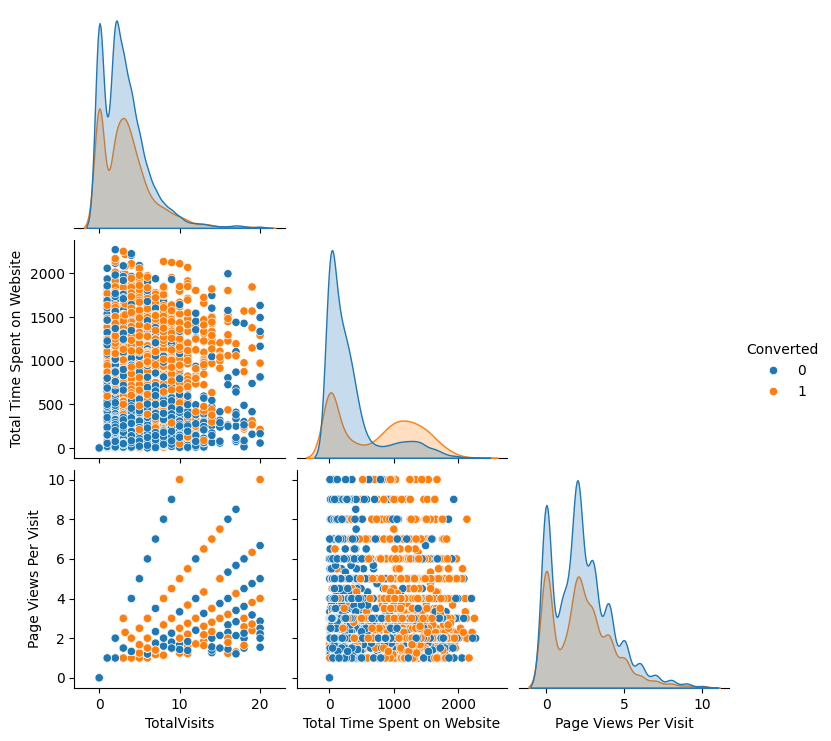

In [58]:
# Let's plot the data for all the columns vs "Converted" column

sns.pairplot(data, hue="Converted", corner=True)
plt.show()

Some correlation between Page Views Per Visit and TotalVisits columns exists

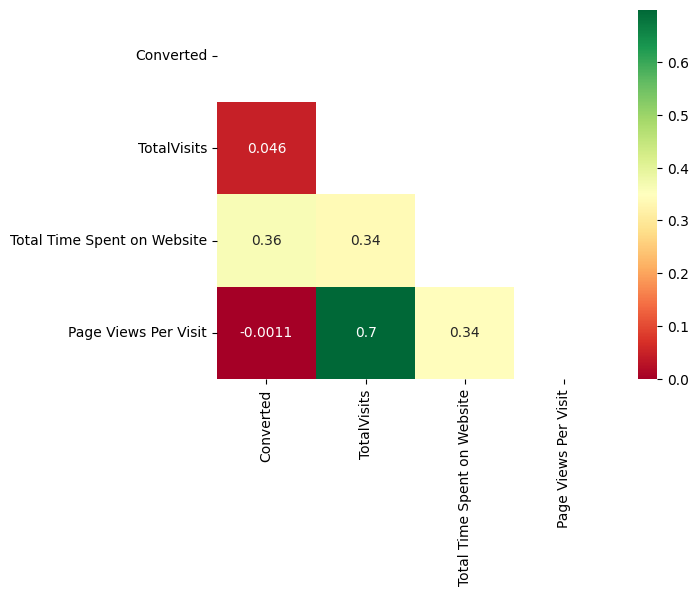

In [59]:
# Let's plot a heatmap of the data
mask = np.triu(np.ones_like(data.corr(numeric_only=True)))
sns.heatmap(data.corr(numeric_only=True), annot=True, mask=mask, cmap='RdYlGn')
plt.show()

A correlation of 0.7 exists between Page Views Per Visit and TotalVisits columns. Hence we can drop the Page Views Per Visit column

In [60]:
# Let's drop the Page Views Per Visit column

data = data.drop("Page Views Per Visit", axis=1)
data.shape

(9142, 12)

In [61]:
# Let's rename the column "A free copy of Mastering The Interview" to "SampleInterviewCourse"

data.rename(columns={"A free copy of Mastering The Interview": "SampleInterviewCourse"}, inplace=True)

In [62]:
# Let's create dummies for each categorical column

cat_cols = [i for i in data.columns if data[i].dtype =='object']

data = pd.get_dummies(data, columns=cat_cols, drop_first=True, dtype=int)
data.shape

(9142, 27)

In [63]:
# Let's view the data 

data.head()

,Converted,TotalVisits,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Redirection,Lead Source_Search,Lead Source_SocialMedia,...,Tags_Interested in other courses,Tags_Others,Tags_Ringing,Tags_Will revert after reading the email,SampleInterviewCourse_Yes,Last Notable Activity_Enquired,Last Notable Activity_Modified,Last Notable Activity_Others,GroupedSpecialisation_Management,GroupedSpecialisation_Others
0,0,0.0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
1,0,5.0,674,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2,1,2.0,1532,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
3,0,1.0,305,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,1,2.0,1428,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0


In [64]:
# Let's split the data into test and training data

X = data.drop("Converted", axis=1)
y = data["Converted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
# Let's Normalize the X_train and X_test

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [66]:
# Let's build a Logistic Regression model with all the variables

logreg = LogisticRegression(n_jobs=-1, random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [67]:
# Let's predict the output with the model built

y_pred = logreg.predict(X_test)

# Let's check the accuracy

print('Accuracy of logistic regression classifier on test set with all the columns: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set with all the columns: 0.89


In [68]:
# Let's remove a few columns using Recursive Feature Elimination (RFE)
logreg = LogisticRegression(n_jobs=-1,random_state=42)
selector = RFE(logreg, n_features_to_select=15)
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]
selected_columns

Index(['TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Origin_Quick Add Form',
       'Lead Source_SocialMedia', 'Do Not Email_Yes', 'Occupation_Housewife',
       'Occupation_Other', 'Occupation_Student', 'Occupation_Unemployed',
       'Occupation_Working Professional', 'Tags_Others', 'Tags_Ringing',
       'Tags_Will revert after reading the email',
       'Last Notable Activity_Enquired'],
      dtype='object')

In [69]:
# Let's check the VIF of columns selected from the RFE model with 15 features selected
X_train1 = X_train[selected_columns]
X_test1 = X_test[selected_columns]

def vif(df):
    vif_df = pd.DataFrame()
    vif_df['features'] = df.columns
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

vif_df = vif(X_train1)

vif_df

,features,VIF
0,TotalVisits,3.144197
1,Total Time Spent on Website,2.429391
2,Lead Origin_Lead Add Form,1.407261
3,Lead Origin_Quick Add Form,1.004336
4,Lead Source_SocialMedia,1.949274
5,Do Not Email_Yes,1.112207
6,Occupation_Housewife,1.019091
7,Occupation_Other,1.028352
8,Occupation_Student,1.153316
9,Occupation_Unemployed,12.061020


In [87]:
# Let's check the p-values of the columns we got to see if they are not selected by chance and have a statistical significance

# X_train1 = X_train1.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_train_sm = sm.add_constant(X_train1)
# logm = sm.Logit(y_train, X_train_sm)
# result = logm.fit()
# result.summary()

When we execute the above code, we get the following error message:

#### LinAlgError: Singular matrix

The above error comes when there is a high correlation between some of the columns in the X_train1 data. Let's check its heatmap to see it.

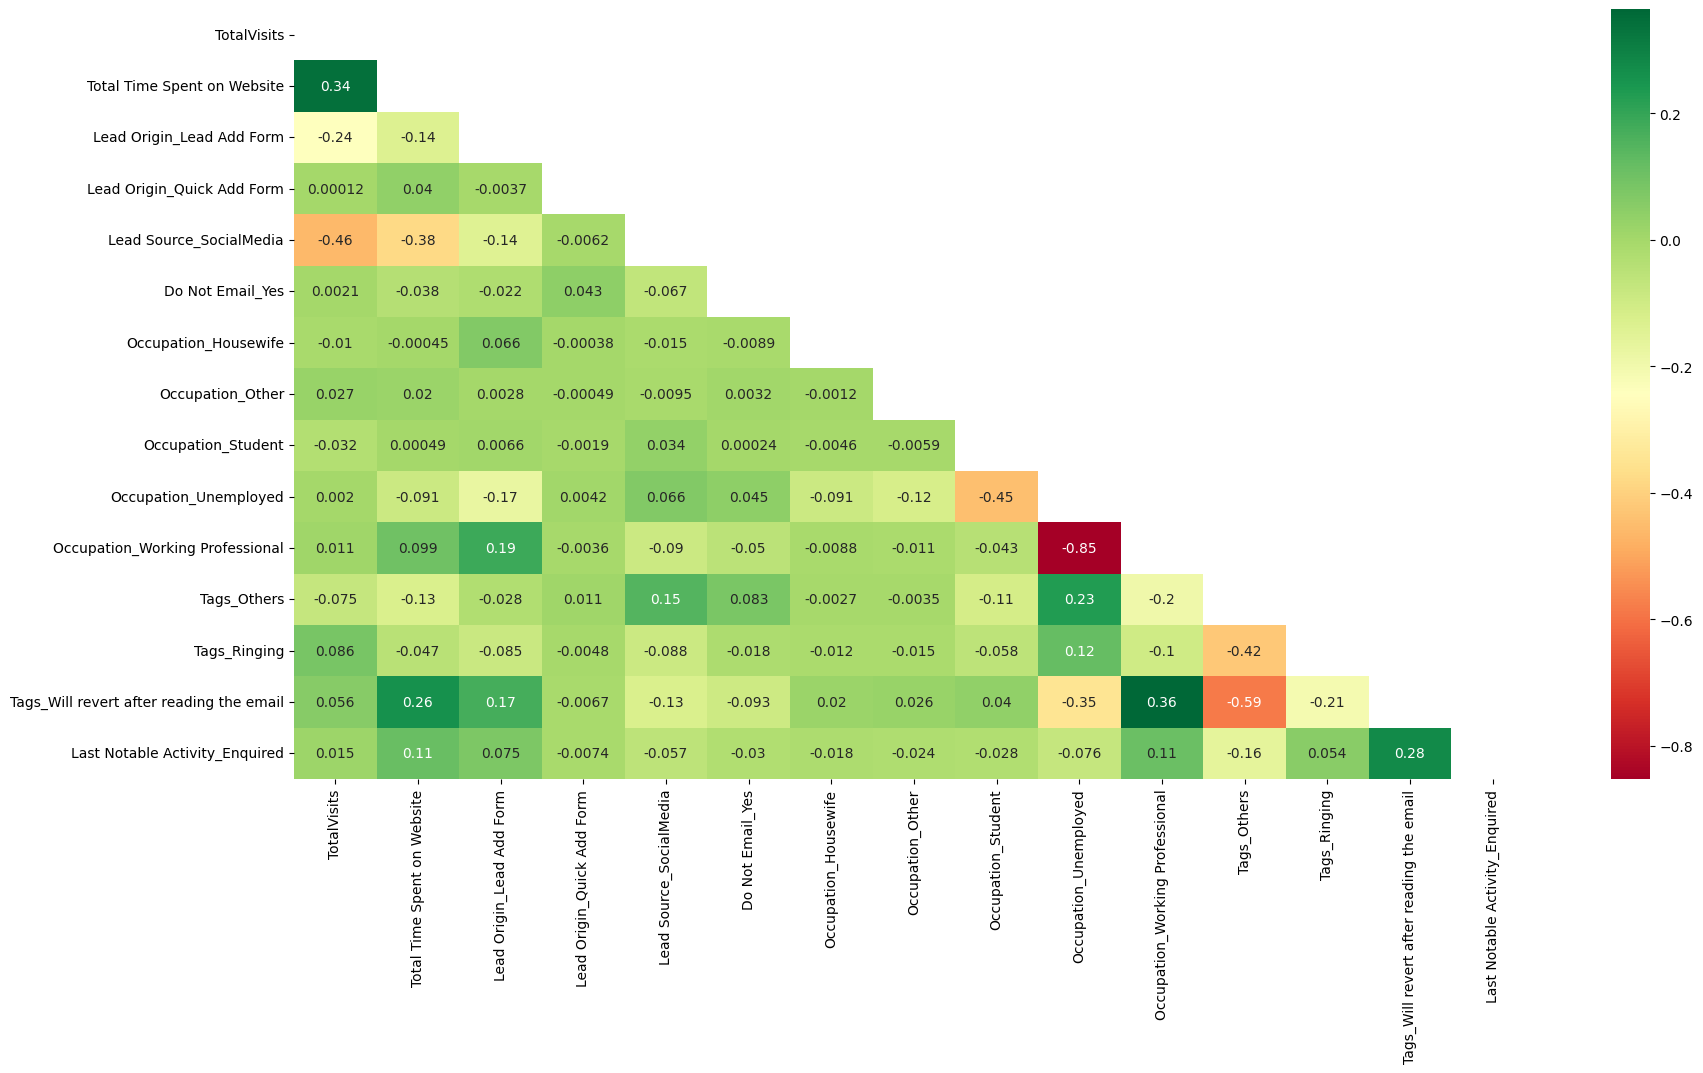

In [71]:
# Let's plot a heatmap of the X_train1 data

mk = np.triu(np.ones_like(X_test1.corr()))
plt.figure(figsize=(20,10))
sns.heatmap(X_train1.corr(),cmap='RdYlGn',mask=mk,annot=True)
plt.show()

From the above, we can see that a great negative correlation between "Occupation_Unemployed" and "Occupation_Working Professional" is available, which is causing issue in building a model.
Let's drop the column "Occupation_Unemployed" from the X_train1 data.

In [72]:
# Let's drop the column "Occupation_Unemployed" from the X_train1 and X_test1 data

X_train1 = X_train1.drop("Occupation_Unemployed", axis=1)
X_test1 = X_test1.drop("Occupation_Unemployed", axis=1)

In [73]:
# Let's continue building the model

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

         Current function value: 0.270803
         Iterations: 35


c:\Users\aravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6384
Method:                           MLE   Df Model:                           14
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5938
Time:                        01:08:37   Log-Likelihood:                -1732.9
converged:                      False   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -5.9016      0.356    -16.580      0.000      -6.599      -5.204
TotalVisits                                  1.0330      0.337      3.062      0.002       0.372       1.694
Total Time Spent on Website                  4.4693      0.216     20.659      0.000       4.045       4.893
Lead Origin_Lead Add Form                    4.4714      0.234     19.118      0.000       4.013       4.930
Lead Origin_Quick Add Form                  18.4582      1e+04      0.002      0.999   -1.96e+04    1.96e+04
Lead Source_SocialMedia                      0.9879      0.136      7.247      0.000       0.721       1.255
Do Not Email_Yes                            -1.7182      0.220     -7.805      0.000      -2.150      -1.287
Occupation_Housewife                        16.9466   2481.535      0.007      0.995   -4846.772    4880.665
Occupation_Other                            -0.1675      0.908     -0.184      0.854      -1.948       1.613
Occupation_Student                           0.0342      0.455      0.075      0.940      -0.857       0.925
Occupation_Working Professional              1.8566      0.278      6.684      0.000       1.312       2.401
Tags_Others                                  3.0547      0.340      8.994      0.000       2.389       3.720
Tags_Ringing                                -0.4126      0.412     -1.001      0.317      -1.221       0.395
Tags_Will revert after reading the email     6.8535      0.371     18.485      0.000       6.127       7.580
Last Notable Activity_Enquired               1.6170      0.100     16.224      0.000       1.422       1.812
============================================================================================================
"""

From the above, it is seen that the "Lead Origin_Quick Add Form" column is having the most high p-value and hence needs to be dropped.

In [74]:
# Dropping the "Lead Origin_Quick Add Form" column

X_train1 = X_train1.drop("Lead Origin_Quick Add Form", axis=1)
X_test1 = X_test1.drop("Lead Origin_Quick Add Form", axis=1)

In [75]:
# Build the model again to check the p-values

X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

         Current function value: 0.270913
         Iterations: 35


c:\Users\aravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6385
Method:                           MLE   Df Model:                           13
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5937
Time:                        01:08:37   Log-Likelihood:                -1733.6
converged:                      False   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -5.9065      0.356    -16.591      0.000      -6.604      -5.209
TotalVisits                                  1.0284      0.337      3.048      0.002       0.367       1.690
Total Time Spent on Website                  4.4834      0.216     20.754      0.000       4.060       4.907
Lead Origin_Lead Add Form                    4.4718      0.234     19.122      0.000       4.013       4.930
Lead Source_SocialMedia                      0.9904      0.136      7.266      0.000       0.723       1.258
Do Not Email_Yes                            -1.6957      0.218     -7.778      0.000      -2.123      -1.268
Occupation_Housewife                        14.4849    725.123      0.020      0.984   -1406.730    1435.700
Occupation_Other                            -0.1730      0.908     -0.191      0.849      -1.952       1.606
Occupation_Student                           0.0313      0.454      0.069      0.945      -0.859       0.922
Occupation_Working Professional              1.8555      0.278      6.680      0.000       1.311       2.400
Tags_Others                                  3.0571      0.340      9.000      0.000       2.391       3.723
Tags_Ringing                                -0.4115      0.412     -0.998      0.318      -1.220       0.397
Tags_Will revert after reading the email     6.8552      0.371     18.486      0.000       6.128       7.582
Last Notable Activity_Enquired               1.6155      0.100     16.210      0.000       1.420       1.811
============================================================================================================
"""

"Occupation_Housewife" has the high p-value here. Let's drop it and continue building the model

In [76]:
# Drop the "Occupation_Housewife" column

X_train1 = X_train1.drop("Occupation_Housewife", axis=1)
X_test1 = X_test1.drop("Occupation_Housewife", axis=1)

# Build the model again to check the p-values

X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.271182
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6386
Method:                           MLE   Df Model:                           12
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5933
Time:                        01:08:37   Log-Likelihood:                -1735.3
converged:                       True   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -5.9050      0.356    -16.588      0.000      -6.603      -5.207
TotalVisits                                  1.0232      0.337      3.033      0.002       0.362       1.684
Total Time Spent on Website                  4.4842      0.216     20.763      0.000       4.061       4.908
Lead Origin_Lead Add Form                    4.4772      0.234     19.171      0.000       4.019       4.935
Lead Source_SocialMedia                      0.9873      0.136      7.247      0.000       0.720       1.254
Do Not Email_Yes                            -1.6983      0.218     -7.789      0.000      -2.126      -1.271
Occupation_Other                            -0.1752      0.908     -0.193      0.847      -1.954       1.604
Occupation_Student                           0.0299      0.454      0.066      0.948      -0.861       0.920
Occupation_Working Professional              1.8529      0.278      6.670      0.000       1.308       2.397
Tags_Others                                  3.0597      0.340      9.008      0.000       2.394       3.725
Tags_Ringing                                -0.4114      0.412     -0.998      0.318      -1.220       0.397
Tags_Will revert after reading the email     6.8564      0.371     18.490      0.000       6.130       7.583
Last Notable Activity_Enquired               1.6131      0.100     16.188      0.000       1.418       1.808
============================================================================================================
"""

"Occupation_Student" has the high p-value here. Let's drop it and continue building the model

In [77]:
# Drop the "Occupation_Student" column

X_train1 = X_train1.drop("Occupation_Student", axis=1)
X_test1 = X_test1.drop("Occupation_Student", axis=1)

# Build the model again to check the p-values

X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.271182
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6387
Method:                           MLE   Df Model:                           11
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5933
Time:                        01:08:39   Log-Likelihood:                -1735.3
converged:                       True   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -5.9024      0.354    -16.679      0.000      -6.596      -5.209
TotalVisits                                  1.0234      0.337      3.034      0.002       0.362       1.684
Total Time Spent on Website                  4.4845      0.216     20.766      0.000       4.061       4.908
Lead Origin_Lead Add Form                    4.4773      0.234     19.173      0.000       4.020       4.935
Lead Source_SocialMedia                      0.9874      0.136      7.248      0.000       0.720       1.254
Do Not Email_Yes                            -1.6978      0.218     -7.792      0.000      -2.125      -1.271
Occupation_Other                            -0.1757      0.908     -0.194      0.847      -1.955       1.603
Occupation_Working Professional              1.8524      0.278      6.671      0.000       1.308       2.397
Tags_Others                                  3.0573      0.338      9.056      0.000       2.396       3.719
Tags_Ringing                                -0.4141      0.410     -1.009      0.313      -1.218       0.390
Tags_Will revert after reading the email     6.8547      0.370     18.527      0.000       6.130       7.580
Last Notable Activity_Enquired               1.6130      0.100     16.187      0.000       1.418       1.808
============================================================================================================
"""

"Occupation_Other" has the high p-value here. Let's drop it and continue building the model

In [78]:
# Dropping the "Occupation_Other" column

X_train1 = X_train1.drop("Occupation_Other", axis=1)
X_test1 = X_test1.drop("Occupation_Other", axis=1)

# Build the model again to check the p-values

X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.271185
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6388
Method:                           MLE   Df Model:                           10
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5932
Time:                        01:08:40   Log-Likelihood:                -1735.3
converged:                       True   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -5.9019      0.354    -16.679      0.000      -6.595      -5.208
TotalVisits                                  1.0221      0.337      3.032      0.002       0.361       1.683
Total Time Spent on Website                  4.4833      0.216     20.771      0.000       4.060       4.906
Lead Origin_Lead Add Form                    4.4772      0.234     19.173      0.000       4.019       4.935
Lead Source_SocialMedia                      0.9871      0.136      7.247      0.000       0.720       1.254
Do Not Email_Yes                            -1.6989      0.218     -7.800      0.000      -2.126      -1.272
Occupation_Working Professional              1.8530      0.278      6.674      0.000       1.309       2.397
Tags_Others                                  3.0568      0.338      9.055      0.000       2.395       3.718
Tags_Ringing                                -0.4143      0.410     -1.010      0.313      -1.218       0.390
Tags_Will revert after reading the email     6.8533      0.370     18.528      0.000       6.128       7.578
Last Notable Activity_Enquired               1.6135      0.100     16.198      0.000       1.418       1.809
============================================================================================================
"""

"Tags_Ringing" has the high p-value here. Let's drop it and continue building the model

In [79]:
# Dropping the "Tags_Ringing" column

X_train1 = X_train1.drop("Tags_Ringing", axis=1)
X_test1 = X_test1.drop("Tags_Ringing", axis=1)

# Build the model again to check the p-values

X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.271261
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6399
Model:                          Logit   Df Residuals:                     6389
Method:                           MLE   Df Model:                            9
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5931
Time:                        01:08:41   Log-Likelihood:                -1735.8
converged:                       True   LL-Null:                       -4266.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -6.1842      0.237    -26.086      0.000      -6.649      -5.720
TotalVisits                                  1.0079      0.336      2.997      0.003       0.349       1.667
Total Time Spent on Website                  4.4821      0.216     20.764      0.000       4.059       4.905
Lead Origin_Lead Add Form                    4.4583      0.232     19.228      0.000       4.004       4.913
Lead Source_SocialMedia                      0.9872      0.136      7.250      0.000       0.720       1.254
Do Not Email_Yes                            -1.6958      0.218     -7.796      0.000      -2.122      -1.269
Occupation_Working Professional              1.8685      0.279      6.690      0.000       1.321       2.416
Tags_Others                                  3.3457      0.202     16.580      0.000       2.950       3.741
Tags_Will revert after reading the email     7.1400      0.255     28.015      0.000       6.640       7.640
Last Notable Activity_Enquired               1.6000      0.099     16.242      0.000       1.407       1.793
============================================================================================================
"""

In [80]:
# Let's see the VIF of these column in the X_train_sm data

vif_df = vif(X_train_sm)
vif_df

,features,VIF
0,const,8.098338
1,TotalVisits,1.480336
2,Total Time Spent on Website,1.361556
3,Lead Origin_Lead Add Form,1.288134
4,Lead Source_SocialMedia,1.568850
5,Do Not Email_Yes,1.022562
6,Occupation_Working Professional,1.176945
7,Tags_Others,1.571941
8,Tags_Will revert after reading the email,1.923809
9,Last Notable Activity_Enquired,1.087695


In [81]:
# Let's build the model again with these columns and check the model performance
X_train_sm = X_train_sm.drop('const',axis=1)
X_train2 = X_train1[X_train_sm.columns]
X_test2 = X_test1[X_train_sm.columns]

logreg = LogisticRegression(n_jobs=-1, random_state=42)

logreg.fit(X_train2, y_train)

y_pred = logreg.predict(X_test2)

In [82]:
# Let's do the model evaluation
print(f'Acuuracy of the model: {round(accuracy_score(y_test,y_pred),2)}')

print(f'Precision: {round(precision_score(y_test, y_pred),2)}')

print(f'Recall: {round(recall_score(y_test, y_pred),2)}')

print(f'F1 Score: {round(f1_score(y_test, y_pred),2)}')

Acuuracy of the model: 0.89
Precision: 0.91
Recall: 0.79
F1 Score: 0.85


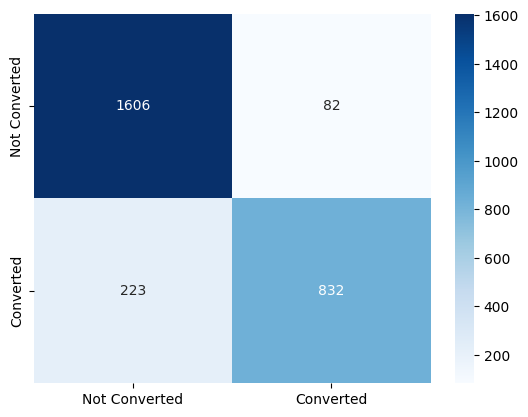

In [83]:
# Let's get the confusion matrix

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.show()